## Provider Fraud Detection - Exploratory Data Analysis

## The goal of this EDA portion will be to understand the data I produced in the Wrangling work, find issues, and decide on modeling & preprocessing choices.

In [ ]:
# importing needed modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import ks_2samp



from pathlib import Path
import os
from IPython.display import display

# show plots inline
%matplotlib inline

In [ ]:
AS_OF_STR = "2023-12-31"
PARQUET_DIR = Path("curated/training") / f"providers_nn_asof_{AS_OF_STR}.parquet"


# loading the final dataframe from the data wrangling step
df = pd.read_parquet(PARQUET_DIR, engine="pyarrow")
print(df.shape)
df.head()

(191700, 29)


,npi,state_abbr,zip5,entity_type_code,primary_taxonomy,npi_age_days,is_active,is_organization_subpart,is_sole_proprietor,total_services,...,w_stddev_submitted_charge,charge_allowed_ratio,payment_allowed_ratio,services_per_bene,bene_days_per_bene,has_puf,ever_excluded_asof,excluded_asof,is_fraud,is_excluded_asof
0,1003003179,NJ,08823,2.0,332B00000X,5934.0,1,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0
1,1003019233,IA,52240,2.0,310400000X,6052.0,1,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0
2,1003019639,NY,12180,1.0,133V00000X,6048.0,1,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0
3,1003031550,WI,53154,2.0,251300000X,6102.0,1,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0
4,1003033556,CA,90061,2.0,1223G0001X,6100.0,1,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0


In [3]:
# exploring the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191700 entries, 0 to 191699
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   npi                        191700 non-null  object 
 1   state_abbr                 183741 non-null  object 
 2   zip5                       183829 non-null  object 
 3   entity_type_code           183830 non-null  float64
 4   primary_taxonomy           183830 non-null  object 
 5   npi_age_days               183830 non-null  float64
 6   is_active                  191700 non-null  int32  
 7   is_organization_subpart    38217 non-null   float64
 8   is_sole_proprietor         143315 non-null  float64
 9   total_services             191700 non-null  float64
 10  total_beneficiaries        191700 non-null  float64
 11  total_bene_day_services    191700 non-null  float64
 12  num_unique_procedures      191700 non-null  float64
 13  frac_drug_services         19

In [4]:
# exploring some basic statistics
df.describe()

,entity_type_code,npi_age_days,is_active,is_organization_subpart,is_sole_proprietor,total_services,total_beneficiaries,total_bene_day_services,num_unique_procedures,frac_drug_services,...,w_stddev_submitted_charge,charge_allowed_ratio,payment_allowed_ratio,services_per_bene,bene_days_per_bene,has_puf,ever_excluded_asof,excluded_asof,is_fraud,is_excluded_asof
count,183830.000000,183830.000000,191700.000000,38217.000000,143315.000000,1.917000e+05,191700.000000,191700.000000,191700.00000,191700.000000,...,191700.000000,191700.000000,191700.000000,191700.000000,191700.000000,191700.000000,6711.0,6711.0,191700.000000,191700.000000
mean,1.207893,3698.010064,0.958946,0.082319,0.335010,2.830473e+02,85.584048,139.971054,1.10711,0.005294,...,27.153017,0.509726,0.106945,0.450855,0.311179,0.139656,1.0,1.0,0.035008,0.035008
std,0.405801,2230.350420,0.198415,0.274854,0.471996,6.053471e+03,1273.968183,2190.487061,4.66307,0.040101,...,233.222103,1.948240,0.267107,3.194090,1.347530,0.346630,0.0,0.0,0.183800,0.183800
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000
25%,1.000000,1598.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000
50%,1.000000,3796.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000
75%,1.000000,6095.000000,1.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000
max,2.000000,6796.000000,1.000000,1.000000,1.000000,1.547347e+06,391196.000000,587072.000000,425.00000,1.000000,...,33931.716585,160.854829,1.000000,439.099462,71.500000,1.000000,1.0,1.0,1.000000,1.000000


In [5]:
# exploring the columns
df.columns

Index(['npi', 'state_abbr', 'zip5', 'entity_type_code', 'primary_taxonomy',
       'npi_age_days', 'is_active', 'is_organization_subpart',
       'is_sole_proprietor', 'total_services', 'total_beneficiaries',
       'total_bene_day_services', 'num_unique_procedures',
       'frac_drug_services', 'frac_missing_zip', 'w_avg_submitted_charge',
       'w_avg_allowed', 'w_avg_payment', 'w_var_submitted_charge',
       'w_stddev_submitted_charge', 'charge_allowed_ratio',
       'payment_allowed_ratio', 'services_per_bene', 'bene_days_per_bene',
       'has_puf', 'ever_excluded_asof', 'excluded_asof', 'is_fraud',
       'is_excluded_asof'],
      dtype='object')

In [ ]:
# data profile summary
prof = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "non_null": df.notna().sum(),
    "missing_pct": df.isna().mean().round(4),
    "n_unique": df.nunique(dropna=True)
}).sort_index()
display(prof.head(40).style.format({"missing_pct":"{:.2%}"}))

# Numeric distribution snapshot (trimmed at 99th pct for readability)
num_preview = df.select_dtypes(include=[np.number]).copy()
for c in num_preview.columns:
    num_preview[c] = num_preview[c].clip(upper=num_preview[c].quantile(0.99))
ax = num_preview.hist(bins=40, figsize=(14,10))
plt.suptitle("Numeric feature distributions (clipped at 99th pct)", y=1.02)
plt.tight_layout()
plt.show()

# Categorical cardinalities (top 20)
cat_preview = df.select_dtypes(exclude=[np.number]).columns.tolist()
for c in cat_preview:
    vc = df[c].value_counts(dropna=False).head(20)
    print(f"\nTop levels for {c} (showing up to 20)")
    display(vc)

In [6]:
# exploring the shape of the data
print(f'Shape of the Provider Fraud Detection dataset: {df.shape}')

Shape of the Provider Fraud Detection dataset: (191700, 29)


In [ ]:
# checking for the missing values for each column in this dataset
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns = ['count', 'percent']
missing.sort_values(by='count', ascending=False)


,count,perecent
excluded_asof,184989,96.499218
ever_excluded_asof,184989,96.499218
w_var_submitted_charge,164928,86.034429
is_organization_subpart,153483,80.064163
is_sole_proprietor,48385,25.239958
state_abbr,7959,4.151800
zip5,7871,4.105895
entity_type_code,7870,4.105373
primary_taxonomy,7870,4.105373
npi_age_days,7870,4.105373


In [8]:
# dropping redudant/raw label columns
df = df.drop(columns=["ever_excluded_asof", "excluded_asof", "w_var_submitted_charge"], errors="ignore")

In [9]:
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191700 entries, 0 to 191699
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   npi                        191700 non-null  object 
 1   state_abbr                 183741 non-null  object 
 2   zip5                       183829 non-null  object 
 3   entity_type_code           183830 non-null  float64
 4   primary_taxonomy           183830 non-null  object 
 5   npi_age_days               183830 non-null  float64
 6   is_active                  191700 non-null  int32  
 7   is_organization_subpart    38217 non-null   float64
 8   is_sole_proprietor         143315 non-null  float64
 9   total_services             191700 non-null  float64
 10  total_beneficiaries        191700 non-null  float64
 11  total_bene_day_services    191700 non-null  float64
 12  num_unique_procedures      191700 non-null  float64
 13  frac_drug_services         19

Index(['npi', 'state_abbr', 'zip5', 'entity_type_code', 'primary_taxonomy',
       'npi_age_days', 'is_active', 'is_organization_subpart',
       'is_sole_proprietor', 'total_services', 'total_beneficiaries',
       'total_bene_day_services', 'num_unique_procedures',
       'frac_drug_services', 'frac_missing_zip', 'w_avg_submitted_charge',
       'w_avg_allowed', 'w_avg_payment', 'w_stddev_submitted_charge',
       'charge_allowed_ratio', 'payment_allowed_ratio', 'services_per_bene',
       'bene_days_per_bene', 'has_puf', 'is_fraud', 'is_excluded_asof'],
      dtype='object')

In [10]:
# renaming the columns to be more readable

rename_map = {
    "state_abbr": "state",
    "zip5": "zip5",
    "entity_type_code": "entity_type", # 1= individual, 2=organization
    "primary_taxonomy": "taxonomy",
    "npi_age_days": "days_since_enrollment",
    "is_active": "npi_active",
    "is_organization_subpart": "org_subpart_flag",
    "is_sole_proprietor": "sole_proprietor_flag",
    "total_services": "services_total",
    "total_beneficiaries": "beneficiaries_total",
    "total_bene_day_services": "beneficiary_days_total",
    "num_unique_procedures": "hcpcs_unique_count",
    "frac_drug_services": "drug_services_rate",
    "frac_missing_zip": "missing_zip_rate",
    "w_avg_submitted_charge": "avg_charge_w",
    "w_avg_allowed": "avg_allowed_w",
    "w_avg_payment": "avg_payment_w",
    "w_stddev_submitted_charge": "charge_std_w",
    "charge_allowed_ratio": "charge_to_allowed",
    "payment_allowed_ratio": "payment_to_allowed",
    "services_per_bene": "services_per_beneficiary",
    "bene_days_per_bene": "beneficiary_days_per_beneficiary",
    "has_puf": "has_claims_features",
    "is_fraud": "label_fraud", # this will be my target feature
    "is_excluded_asof": "status_excluded_asof" # this is only for reporting purposes, not used in modeling
}

df = df.rename(columns=rename_map)


In [11]:
# Basic label sanity
print(df["label_fraud"].value_counts(dropna=False))
print(f"Prevalence (downsampled): {df['label_fraud'].mean():.2%}")

label_fraud
0    184989
1      6711
Name: count, dtype: int64
Prevalence (downsampled): 3.50%


In [12]:
# Duplicates on primary key
dup_npi = df["npi"].duplicated().sum()
print("Duplicate NPIs:", dup_npi)

Duplicate NPIs: 0


In [ ]:
# Optional: consolidate duplicates (choose policy)
if dup_npi > 0:
    # If you have a time column (adjust the name), keep the latest record per NPI
    time_col_guess = next((c for c in df.columns if "asof" in c.lower() or "date" in c.lower()), None)
    if time_col_guess is not None:
        df = (df.sort_values(time_col_guess)
                .groupby("npi", as_index=False)
                .tail(1))
    else:
        # Otherwise aggregate numerics, and mark label as any positive
        agg_spec = {c: "mean" for c in df.select_dtypes(include=[np.number]).columns if c not in ["label_fraud"]}
        agg_spec["label_fraud"] = "max"
        keep_first = [c for c in df.columns if c not in agg_spec and c != "npi"]
        df = (df.groupby("npi", as_index=False)
                .agg(agg_spec)
                .merge(df[["npi"] + keep_first].drop_duplicates("npi"), on="npi", how="left"))
    print("After NPI de-dup:", df.shape)
    print(f"Prevalence after NPI de-dup: {df['label_fraud'].mean():.2%}")



,rows,fraud_rate,pct
has_claims_features,,,
0,164928,4.06%,86.0%
1,26772,0.03%,14.0%



Top state by volume within has_claims_features buckets


,has_claims_features,state,rows,fraud_rate
9,0,CA,20356,3.76%
43,0,NY,11687,5.32%
14,0,FL,10830,4.61%
54,0,TX,10004,3.26%
44,0,OH,6759,7.10%
28,0,MI,5927,4.42%
48,0,PA,5585,4.60%
20,0,IL,5342,3.39%
35,0,NC,4443,1.91%
25,0,MA,4405,1.79%



Top entity_type by volume within has_claims_features buckets


,has_claims_features,entity_type,rows,fraud_rate
0,0,1.000000,120337,4.56%
1,0,2.000000,36805,1.20%
2,1,1.000000,25276,0.04%
3,1,2.000000,1412,0.00%



Top taxonomy by volume within has_claims_features buckets


,has_claims_features,taxonomy,rows,fraud_rate
34,0,106S00000X,7280,0.11%
30,0,1041C0700X,6589,1.70%
180,0,183500000X,6534,3.41%
3,0,101YM0800X,6246,2.15%
425,0,225100000X,4555,1.84%
489,0,235Z00000X,4172,0.79%
51,0,1223G0001X,3958,3.34%
760,0,390200000X,3721,0.46%
5,0,101YP2500X,3191,2.70%
225,0,207Q00000X,3185,15.54%


,missing_pct,count
org_subpart_flag,80.1%,153483
sole_proprietor_flag,25.2%,48385
state,4.2%,7959
zip5,4.1%,7871
entity_type,4.1%,7870
taxonomy,4.1%,7870
days_since_enrollment,4.1%,7870
npi,0.0%,0
avg_payment_w,0.0%,0
label_fraud,0.0%,0


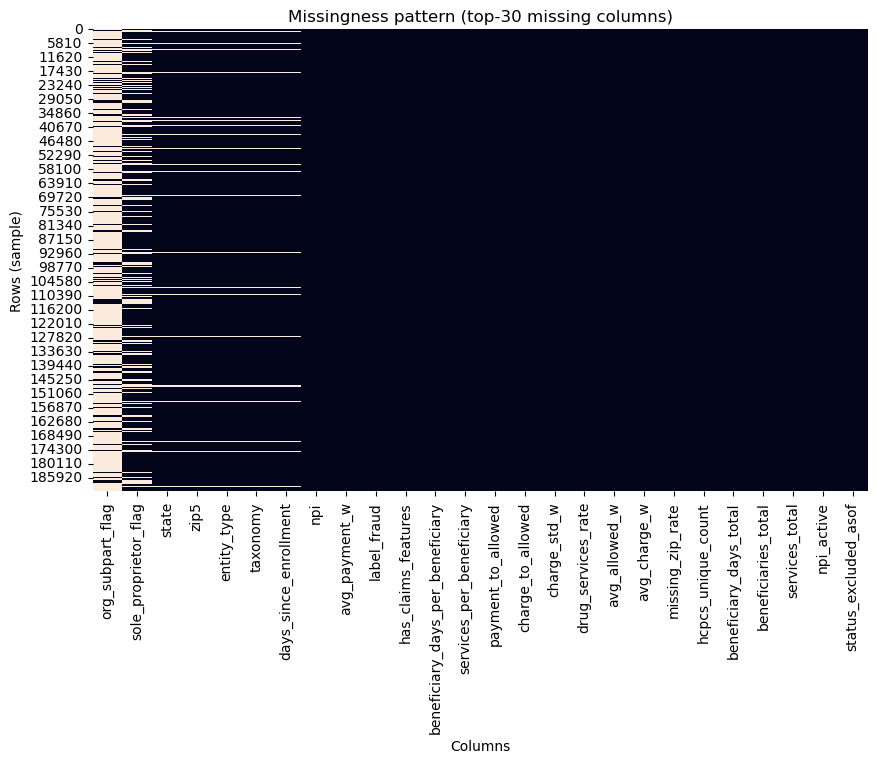


KS test: features with strongest distribution differences by bucket


,feature,ks_stat,p_value
0,avg_allowed_w,1.000000,0.0
18,services_total,1.000000,0.0
17,services_per_beneficiary,1.000000,0.0
16,payment_to_allowed,1.000000,0.0
12,hcpcs_unique_count,1.000000,0.0
11,has_claims_features,1.000000,0.0
19,sole_proprietor_flag,0.149136,0.0
9,drug_services_rate,0.191506,0.0
10,entity_type,0.181307,0.0
7,charge_to_allowed,1.000000,0.0


In [ ]:
# some coverage and completeness checks

# ensuring bucket is clean integers
if "has_claims_features" in df.columns:
    df["has_claims_features"] = df["has_claims_features"].fillna(0).astype(int)
else:
    raise ValueError("Column 'has_claims_features' not found. Expected after wrangling.")

# inserting scaffold guards
assert "label_fraud" in df.columns, "Missing target column 'label_fraud'."
df["label_fraud"] = df["label_fraud"].fillna(0).astype(int)

# cohort size and fraud prevalence by bucket
bucket = (
    df.groupby("has_claims_features")
      .agg(rows=("npi","size"),
           fraud_rate=("label_fraud","mean"))
      .assign(pct=lambda x: x["rows"] / len(df))
      .sort_index()
)
display(bucket.style.format({"pct":"{:.1%}","fraud_rate":"{:.2%}"}))

# slicing the bucket by key categoricals
for col in [c for c in ["state","entity_type","taxonomy"] if c in df.columns]:
    tmp = (df.groupby(["has_claims_features", col])
             .agg(rows=("npi","size"), fraud_rate=("label_fraud","mean"))
             .reset_index())
    # show top 15 by rows within each bucket
    out = tmp.sort_values(["has_claims_features","rows"], ascending=[True,False])\
             .groupby("has_claims_features").head(15)
    print(f"\nTop {col} by volume within has_claims_features buckets")
    display(out.style.format({"fraud_rate":"{:.2%}"}))


# missingness overview: table of top 10 missing columns
miss_tbl = (df.isna().mean().sort_values(ascending=False)
              .to_frame("missing_pct")
              .assign(count=lambda x: (x["missing_pct"]*len(df)).round().astype(int)))
display(miss_tbl.head(10).style.format({"missing_pct":"{:.1%}"}))


# missingness heatmap (subsetting to the 30 most missing columns for visibility)
top_cols = miss_tbl.head(30).index.tolist()
if top_cols:
    plt.figure(figsize=(10,6))
    sns.heatmap(df[top_cols].isna(), cbar=False)
    plt.title("Missingness pattern (top-30 missing columns)")
    plt.xlabel("Columns")
    plt.ylabel("Rows (sample)")
    plt.show()

# having a label leakage check
y = df["label_fraud"].astype(int).values

# Exclude identifier-like numerics from signal checks
id_like = [c for c in ["npi", "tin", "ein", "org_id"] if c in df.columns]

X_num = (df.select_dtypes(include=[np.number])
           .drop(columns=["label_fraud"] + id_like, errors="ignore"))
num_feats = X_num.columns.tolist()

# 1A: Single-feature ROC AUC / AP
rows = []
for f in num_feats:
    # make a 1-D array; fill NaNs with the feature median
    xv = X_num[f].fillna(X_num[f].median()).to_numpy().ravel()
    try:
        # guard: if the feature is constant after fill, AUC/AP are undefined
        if np.all(xv == xv[0]):
            auc, ap = (np.nan, np.nan)
        else:
            auc = roc_auc_score(y, xv)
            ap  = average_precision_score(y, xv)
    except Exception:
        auc, ap = (np.nan, np.nan)
    rows.append((f, auc, ap))

single_auc = (pd.DataFrame(rows, columns=["feature","roc_auc","avg_precision"])
                .sort_values("roc_auc", ascending=False))
print("Possible leakage (AUC > 0.85 typically suspicious):")
display(single_auc.head(25))


# 1B: Mutual Information (secondary lens)
mi = mutual_info_classif(X_num.fillna(X_num.median()), y, discrete_features=False, random_state=0)
mi_tbl = pd.DataFrame({"feature": num_feats, "mi": mi}).sort_values("mi", ascending=False)
display(mi_tbl.head(25))

# 1C: Name heuristics
suspect_substrings = ["excluded","sanction","oig","investigat","clawback","recovery",
                      "post","asof_","denial","appeal"]
suspects = [c for c in df.columns if any(s in c.lower() for s in suspect_substrings)]
print("Potentially leaky by name:", suspects)


# addressing redundnancy & multicollinearity (spearman >= 0.95)
num = (df.select_dtypes(include=[np.number])
         .drop(columns=["label_fraud"] + id_like, errors="ignore"))
corr = num.corr(method="spearman").abs()

pairs = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
              .stack()
              .reset_index())
pairs.columns = ["f1","f2","abs_spearman"]
high = pairs[pairs["abs_spearman"]>=0.95].sort_values("abs_spearman", ascending=False)
print("Highly correlated pairs (>=0.95):", len(high))
display(high.head(40))


# checking to see if numeric distributions are different between buckets
num_cols = (df.select_dtypes(include=[np.number])
              .drop(columns=["label_fraud"] + id_like, errors="ignore")
              .columns)

ks_rows = []
for c in num_cols:
    a = df.loc[df["has_claims_features"]==1, c].dropna()
    b = df.loc[df["has_claims_features"]==0, c].dropna()
    if len(a)>50 and len(b)>50:
        stat, p = ks_2samp(a, b)
        ks_rows.append((c, stat, p))
ks_tbl = (pd.DataFrame(ks_rows, columns=["feature","ks_stat","p_value"])
          .sort_values("ks_stat", ascending=False))
print("\nKS test: features with strongest distribution differences by bucket")
display(ks_tbl.head(15))

### The cohort split (has_claims_features) has a giant difference in prevalence. Bucket =1 has rich claims features but it's fraud label prevalence is nearly zero
### There will be two paths I can go about this. 
### The first path can be a 'two-path scoring'. I can train my NN only on has_claims_features=1. For has_claims_features=0 I can ship a lightweight fallback


### The second path will consist of having a single model but being bucket aware. Keeping both buckets but adding missingness flags and consistent imputation for every claims-derived column. Also stratifying train/valid/test by label and bucket

### Based off of the low count of =1's (around 26k rows), I am going to tweak the two-path strategy. 

In [25]:
# cardinality of categorical features (to plan for encoding)
cat_cols = [c for c in ["state","entity_type","taxonomy"] if c in df.columns]
for c in cat_cols:
    vc = df[c].value_counts(dropna=False)
    print(f"\n{c}: {len(vc)} unique values")
    display(vc.head(15))



state: 64 unique values


state
CA      22473
NY      13538
FL      12573
TX      11818
None     7959
OH       7824
PA       6916
MI       6849
IL       6401
NC       5359
MA       5184
WA       4963
NJ       4558
GA       4528
CO       3924
Name: count, dtype: int64


entity_type: 3 unique values


entity_type
1.0    145613
2.0     38217
NaN      7870
Name: count, dtype: int64


taxonomy: 769 unique values


taxonomy
None          7870
106S00000X    7280
1041C0700X    6905
183500000X    6536
101YM0800X    6258
225100000X    6073
207Q00000X    5001
363LF0000X    4836
207R00000X    4474
235Z00000X    4208
1223G0001X    3958
390200000X    3818
111N00000X    3727
363A00000X    3218
101YP2500X    3192
Name: count, dtype: int64

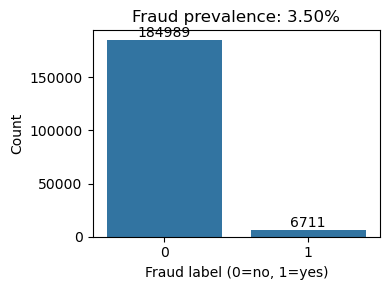

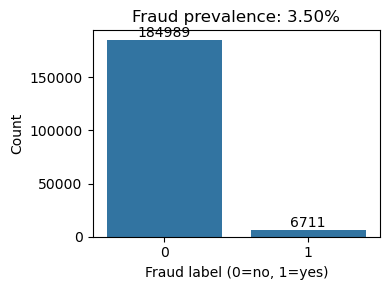

In [20]:
# target feature distribution
fig, ax = plt.subplots(figsize=(4,3))
sns.countplot(x="label_fraud", data=df, ax=ax)
ax.set_xlabel("Fraud label (0=no, 1=yes)")
ax.set_ylabel("Count")
ax.bar_label(ax.containers[0])
ax.set_title(f"Fraud prevalence: {df['label_fraud'].mean():.2%}")
plt.tight_layout()
plt.show()


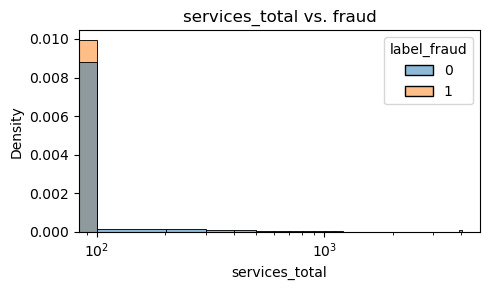

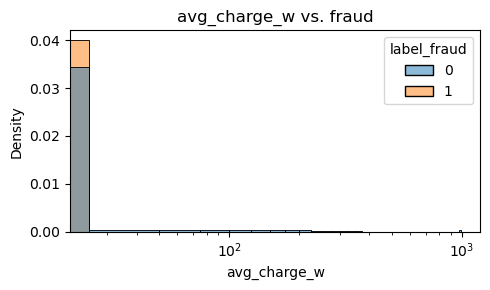

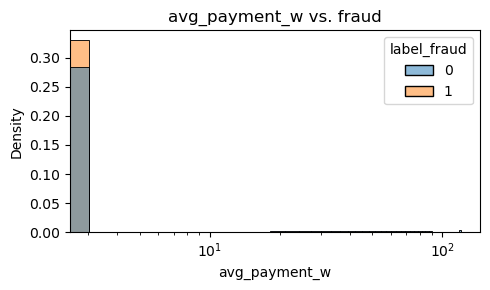

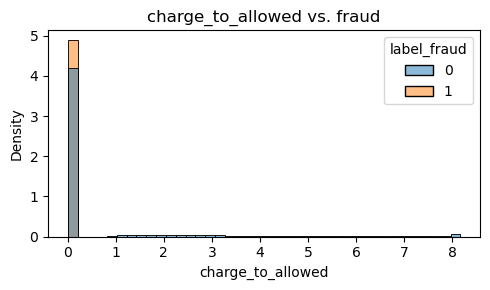

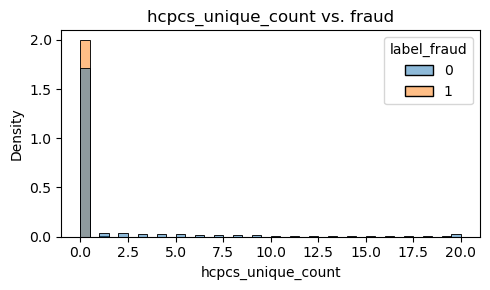

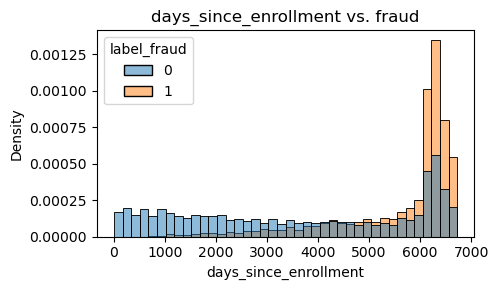

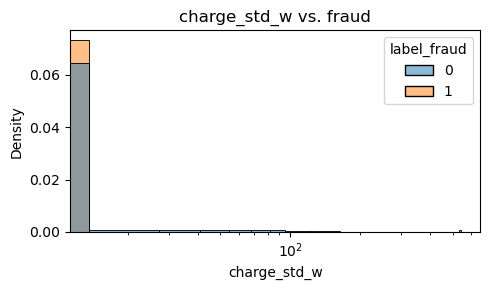

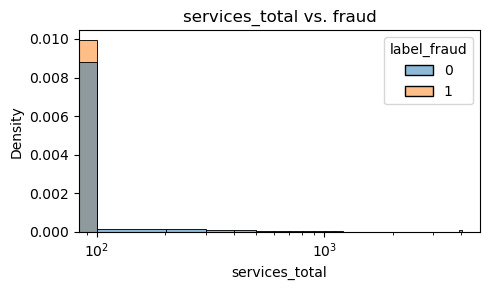

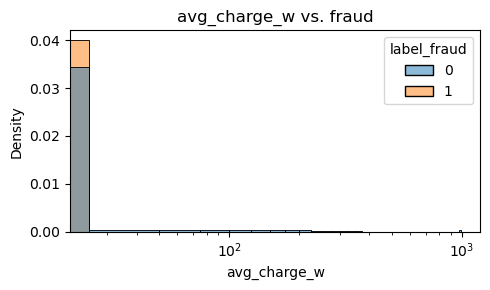

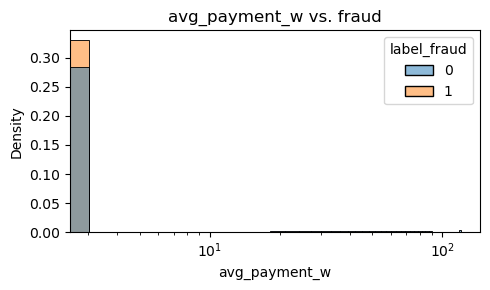

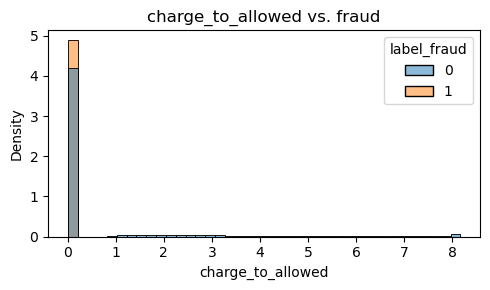

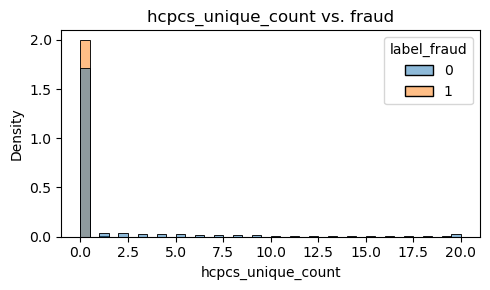

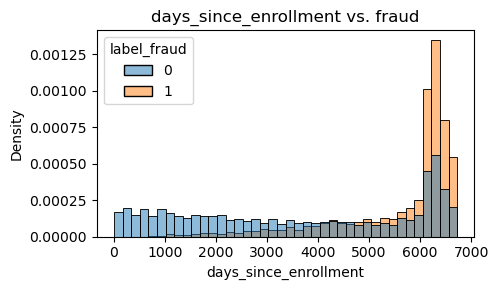

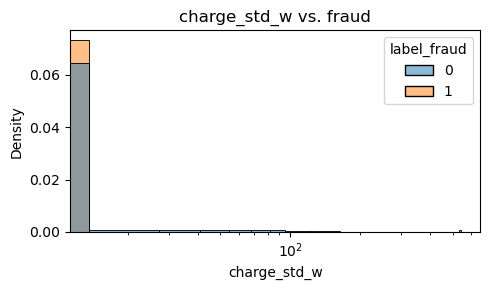

In [22]:
# numeric feature distribution vs target

# choose representative numeric features (adjust as you like)
num_cols_view = [
    "services_total","avg_charge_w","avg_payment_w","charge_to_allowed",
    "hcpcs_unique_count","days_since_enrollment","charge_std_w"
]
present = [c for c in num_cols_view if c in df.columns]

for c in present:
    fig, ax = plt.subplots(figsize=(5,3))
    x = df[c].clip(upper=df[c].quantile(0.99))  # clip for readability
    sns.histplot(x=x, hue=df["label_fraud"], bins=40, stat="density",
                 common_norm=False, ax=ax)
    ax.set_title(f"{c} vs. fraud")
    if c in {"services_total","avg_charge_w","avg_payment_w","charge_std_w"}:
        ax.set_xscale("log")
    plt.tight_layout()
    plt.show()


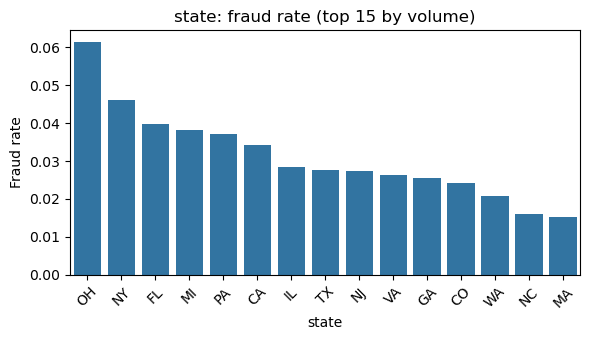

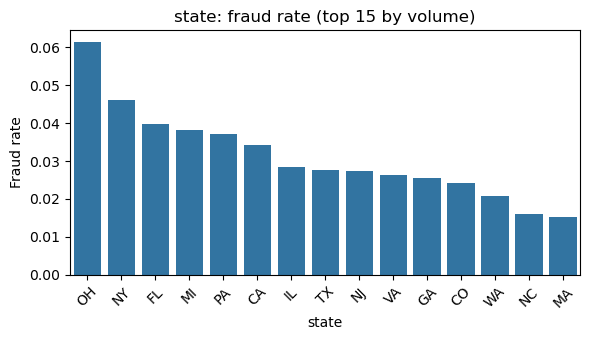

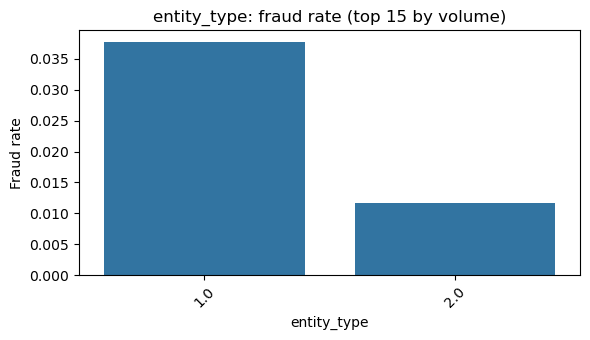

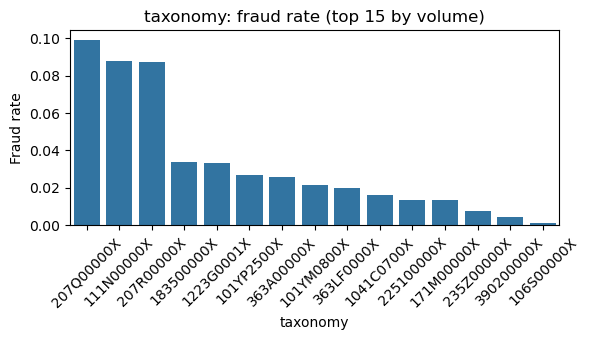

,rate,count
state,,
OH,0.061350,7824
NY,0.046092,13538
FL,0.039688,12573
MI,0.038254,6849
PA,0.037160,6916
CA,0.034085,22473
IL,0.028433,6401
TX,0.027670,11818
NJ,0.027424,4558


,rate,count
entity_type,,
1.0,0.037744,145613
2.0,0.011592,38217


,rate,count
taxonomy,,
207Q00000X,0.099180,5001
111N00000X,0.087738,3727
207R00000X,0.087394,4474
183500000X,0.034119,6536
1223G0001X,0.033350,3958
101YP2500X,0.026942,3192
363A00000X,0.026103,3218
101YM0800X,0.021413,6258
363LF0000X,0.019851,4836


In [27]:
# categorical feature distribution vs target
def plot_cat_rate(df, col, top_n=15):
    if col not in df.columns: return
    top_vals = df[col].value_counts().head(top_n).index
    tmp = (df[df[col].isin(top_vals)]
           .groupby(col)["label_fraud"]
           .agg(rate="mean", count="size")
           .sort_values("rate", ascending=False))
    fig, ax = plt.subplots(figsize=(6,3.5))
    sns.barplot(x=tmp.index.astype(str), y=tmp["rate"], ax=ax)
    ax.set_ylabel("Fraud rate")
    ax.set_xlabel(col)
    ax.set_title(f"{col}: fraud rate (top {top_n} by volume)")
    ax.tick_params(axis="x", rotation=45)
    plt.tight_layout()
    display(tmp)
    
plt.show()


for c in ["state","entity_type","taxonomy"]:
    plot_cat_rate(df, c, top_n=15)


In [ ]:
# rare-category pooling
def rare_pool(frame, col, min_count=200):
    vc = frame[col].value_counts(dropna=False)
    rare_vals = vc[vc < min_count].index
    new_col = f"{col}_rarepooled"
    frame[new_col] = frame[col].where(~frame[col].isin(rare_vals), f"Other_{col}")
    return new_col, vc, rare_vals

pooled_cols = []
for c in [c for c in ["state","entity_type","taxonomy"] if c in df.columns]:
    newc, vc, rares = rare_pool(df, c, min_count=200)  # tune threshold
    pooled_cols.append(newc)
    print(f"{c}: pooled {len(rares)} rare levels into '{newc}'")

In [ ]:
# outlier capping
caps = {}
cap_cols = [c for c in ["services_total","avg_charge_w","avg_payment_w",
                        "charge_to_allowed","payment_to_allowed","charge_std_w"]
            if c in df.columns]
for c in cap_cols:
    caps[c] = {}
    for b in [0,1]:
        q = df.loc[df["has_claims_features"]==b, c].quantile(0.995)
        df.loc[df["has_claims_features"]==b, c] = df.loc[df["has_claims_features"]==b, c].clip(upper=q)
        caps[c][b] = float(q)
print("Recorded caps:", caps)

In [ ]:
preimp = df.copy()

claims_cols = [c for c in preimp.columns if c.endswith("_w") or c in
               ["services_total","hcpcs_unique_count","charge_to_allowed","payment_to_allowed"]]
preimp["claims_feat_coverage"] = 1 - preimp[claims_cols].isna().mean(axis=1) if claims_cols else 0.0
preimp["claims_volume"] = preimp.get("services_total", pd.Series(0, index=preimp.index)).fillna(0)

# Persist missingness as durable features on df (survive imputation)
claims_like = [c for c in preimp.columns if c.endswith("_w")] + \
              [c for c in ["services_total","hcpcs_unique_count"] if c in preimp.columns]
for c in claims_like:
    df[f"miss_{c}"] = preimp[c].isna().astype(int)

In [ ]:
# imputation
num_impute_map = {}
for c in df.select_dtypes(include=[np.number]).columns.difference(["label_fraud"]):
    med0 = df.loc[df["has_claims_features"]==0, c].median()
    med1 = df.loc[df["has_claims_features"]==1, c].median()
    num_impute_map[c] = {0: float(med0) if pd.notna(med0) else 0.0,
                         1: float(med1) if pd.notna(med1) else 0.0}

for b in [0,1]:
    idx = df["has_claims_features"]==b
    for c in num_impute_map:
        df.loc[idx, c] = df.loc[idx, c].fillna(num_impute_map[c][b])

for c in df.select_dtypes(exclude=[np.number]).columns:
    df[c] = df[c].fillna("MISSING")

print("Stored numeric impute map per bucket.")

import json
ARTIFACTS_DIR = Path("curated/training")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

with open(ARTIFACTS_DIR / f"caps_{AS_OF_STR}.json", "w") as f:
    json.dump(caps, f, indent=2)

with open(ARTIFACTS_DIR / f"impute_map_{AS_OF_STR}.json", "w") as f:
    json.dump(num_impute_map, f, indent=2)

print("Saved caps & impute map to:", ARTIFACTS_DIR)

In [ ]:
# target imprint & router drivers
time_col = next((c for c in df.columns
                 if ("month" in c.lower() or "asof" in c.lower()) and c not in ["AS_OF_STR","asof_string"]), None)

if time_col is not None:
    by_time = (df.groupby([time_col, "has_claims_features"])["label_fraud"]
                 .agg(rate="mean", count="size").reset_index())
    print("Fraud rate over time by bucket (last 12 rows):")
    display(by_time.tail(12))

# Router driver candidates (use PRE-IMPUTE snapshot)
print("Router driver summaries (pre-impute view):")
display(preimp[["claims_feat_coverage","claims_volume"]].describe(include="all"))


In [ ]:
def population_stability_index(a, b, bins=20):
    a = pd.Series(a).replace([np.inf, -np.inf], np.nan).dropna()
    b = pd.Series(b).replace([np.inf, -np.inf], np.nan).dropna()
    if a.nunique() < 2 or b.nunique() < 2:
        return 0.0
    qs = np.linspace(0, 1, bins+1)
    cuts = a.quantile(qs).unique()
    a_bins = pd.cut(a, bins=np.unique(cuts), include_lowest=True)
    b_bins = pd.cut(b, bins=np.unique(cuts), include_lowest=True)
    a_pct = a_bins.value_counts(normalize=True, sort=False)
    b_pct = b_bins.value_counts(normalize=True, sort=False)
    psi = ((a_pct - b_pct) * np.log((a_pct + 1e-8) / (b_pct + 1e-8))).sum()
    return float(psi)

if time_col is None:
    df["_fold"] = "train"
    df.loc[df.sample(frac=0.2, random_state=42).index, "_fold"] = "valid"
else:
    ordered = sorted(df[time_col].dropna().unique())
    cutoff = ordered[int(0.8*len(ordered))] if len(ordered) >= 5 else ordered[-1]
    df["_fold"] = np.where(df[time_col] <= cutoff, "train", "valid")

stab=[]
for c in df.select_dtypes(include=[np.number]).columns.difference(["label_fraud"]):
    psi = population_stability_index(df.loc[df["_fold"]=="train", c],
                                     df.loc[df["_fold"]=="valid", c])
    stab.append((c, psi))
psi_tbl = pd.DataFrame(stab, columns=["feature","psi"]).sort_values("psi", ascending=False)
print("Top unstable by PSI:")
display(psi_tbl.head(20))

In [ ]:
ks_rows = []
num_cols_lbl = (df.select_dtypes(include=[np.number])
                  .drop(columns=["label_fraud"] + id_like, errors="ignore")
                  .columns)
for c in num_cols_lbl:
    a = df.loc[df["label_fraud"]==1, c].dropna()
    b = df.loc[df["label_fraud"]==0, c].dropna()
    if len(a)>50 and len(b)>50:
        stat, p = ks_2samp(a, b)
        ks_rows.append((c, stat, p))
ks_lbl = pd.DataFrame(ks_rows, columns=["feature","ks_stat","p_value"])\
         .sort_values("ks_stat", ascending=False)
print("Features with strongest separation (KS):")
display(ks_lbl.head(25))

In [ ]:
print("Candidate router thresholds (pre-impute): share & fraud rate in claims-rich")
for thr_cov in [0.5, 0.7, 0.8, 0.9]:
    for thr_vol in [10, 50, 100]:
        mask = (preimp["claims_feat_coverage"]>=thr_cov) & (preimp["claims_volume"]>=thr_vol)
        share = mask.mean()
        fr = df.loc[mask, "label_fraud"].mean() if share>0 else np.nan
        print(f"coverage≥{thr_cov:0.2f}, volume≥{thr_vol:>3}: share={share:6.2%}, fraud_rate={fr:6.2%}")


In [ ]:
# Correlation heatmap (Spearman, clipped to top 30 most variable features for readability)
num_all = df.select_dtypes(include=[np.number]).drop(columns=["label_fraud"], errors="ignore").copy()
var_rank = num_all.var().sort_values(ascending=False).head(30).index
corr30 = num_all[var_rank].corr(method="spearman")
plt.figure(figsize=(10,8))
sns.heatmap(corr30, cmap="vlag", center=0, square=True)
plt.title("Spearman correlation (top-30 variance features)")
plt.show()

# Pairwise scatter for top 4 discriminators (by KS)
top4 = ks_lbl["feature"].head(4).tolist() if "ks_lbl" in globals() else var_rank[:4].tolist()
sample = df.sample(min(5000, len(df)), random_state=42)  # keep plots light
for i in range(len(top4)-1):
    for j in range(i+1, len(top4)):
        x, y = top4[i], top4[j]
        plt.figure(figsize=(4.5,3.5))
        plt.scatter(sample[x], sample[y], c=sample["label_fraud"], alpha=0.3)
        plt.xlabel(x); plt.ylabel(y); plt.title(f"{x} vs {y} (colored by label)")
        plt.tight_layout(); plt.show()

In [ ]:
feat_notes = []

# (a) Log transforms for heavy-tail monetary/volume
log_cols = [c for c in ["services_total","avg_charge_w","avg_payment_w","charge_std_w"]
            if c in df.columns]
for c in log_cols:
    newc = f"log1p_{c}"
    df[newc] = np.log1p(df[c].clip(lower=0))
    feat_notes.append(newc)

# (b) Ratios & normalized behaviors
if set(["avg_charge_w","avg_allowed_w"]).issubset(df.columns):
    df["charge_over_allowed"] = df["avg_charge_w"] / (df["avg_allowed_w"] + 1e-6)
    feat_notes.append("charge_over_allowed")
if set(["avg_payment_w","avg_allowed_w"]).issubset(df.columns):
    df["payment_over_allowed"] = df["avg_payment_w"] / (df["avg_allowed_w"] + 1e-6)
    feat_notes.append("payment_over_allowed")

# (c) Peer z-scores within taxonomy × state (behavior vs peers)
peer_keys = [k for k in ["taxonomy","state"] if k in df.columns]
peer_base = [c for c in ["services_total","hcpcs_unique_count","avg_charge_w","avg_payment_w"]
             if c in df.columns]
if len(peer_keys) == 2 and peer_base:
    grp = df.groupby(peer_keys)
    for c in peer_base:
        mu = grp[c].transform("mean")
        sd = grp[c].transform("std").replace(0, np.nan)
        newc = f"z_{c}_by_{peer_keys[0]}_{peer_keys[1]}"
        df[newc] = (df[c] - mu) / sd
        feat_notes.append(newc)

# (d) Missingness indicators are already created from PREIMP earlier; keep them as-is
claims_like = [c for c in df.columns if c.endswith("_w")] + [c for c in ["services_total","hcpcs_unique_count"] if c in df.columns]
for c in claims_like:
    mi = f"miss_{c}"
    if mi not in df.columns:
        df[mi] = 0  # should already exist; this is just a safety
    feat_notes.append(mi)


print("Created EDA-only feature candidates:", feat_notes[:10], "… (see df.columns for all)")

In [ ]:
group_keys = [c for c in ["address_std","phone_norm","ein","org_id"] if c in df.columns]
for g in group_keys:
    vc = df[g].value_counts(dropna=True)
    print(f"{g}: unique nodes={vc.size:,} | nodes with >=2 providers={(vc>=2).sum():,}")

In [ ]:
def data_dictionary(frame):
    rows=[]
    for c in frame.columns:
        s = frame[c]
        dtype = str(s.dtype)
        miss = s.isna().mean()
        card = s.nunique(dropna=True)
        row = {"column":c,"dtype":dtype,"missing_pct":miss,"cardinality":card}
        if pd.api.types.is_numeric_dtype(s):
            row.update(dict(min=s.min(skipna=True), max=s.max(skipna=True),
                            mean=s.mean(skipna=True), std=s.std(skipna=True)))
        rows.append(row)
    return pd.DataFrame(rows).sort_values("column")

dd = data_dictionary(df.drop(columns=["_fold"], errors="ignore"))
display(dd.head(30).style.format({"missing_pct":"{:.1%}","mean":"{:.3g}","std":"{:.3g}"}))
dd_path = Path("curated/training") / f"data_dictionary_{AS_OF_STR}.csv"
dd.to_csv(dd_path, index=False)
print("Saved data dictionary to:", dd_path)